In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Initialize vector store
from application.application import Application
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas import EvaluationDataset, evaluate
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (
    Faithfulness,
    LLMContextRecall,
    LLMContextPrecisionWithReference,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity
)

import warnings
warnings.filterwarnings("ignore")

In [13]:


app = Application(reset_collection=False)



In [14]:


llm = ChatOpenAI(model="gpt-4o", temperature=0.0, max_tokens=1000, streaming=False)
evaluator_llm = LangchainLLMWrapper(llm)
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

metrics = [
    # RAG Metrics
    LLMContextRecall(llm=evaluator_llm),
    LLMContextPrecisionWithReference(llm=evaluator_llm),
    ContextEntityRecall(llm=evaluator_llm),
    Faithfulness(llm=evaluator_llm),
    ResponseRelevancy(embeddings=evaluator_embeddings, llm=evaluator_llm),
    NoiseSensitivity(llm=evaluator_llm, focus="relevant"),
]

## Evaluation Set Creation

In [15]:

with open('./data/questions_groundtruth.json', 'r') as file:
    data = json.load(file)
    questions = data['examples']

results = {}

for mode in ["LLM", "Vector Search -> LLM", "Vector Search -> Reranker -> LLM"]:

    sub_result = []

    for question in tqdm(questions, desc=f"{mode} questions"):
        question_text = question['question']
        reference_text = question['answer']

        if mode == "LLM":
            response, docs, elapsed_time = app.ask_llm(question_text)
        elif mode ==  "Vector Search -> LLM":
            response, docs, elapsed_time = app.ask_llm_with_rag(question_text)
        elif mode == "Vector Search -> Reranker -> LLM":
            response, docs, elapsed_time = app.ask_llm_with_rag_and_rerank(question_text)

        sub_result.append(
            {
                    "user_input": question_text,
                    "response": response,
                    "retrieved_contexts": docs,
                    "reference": reference_text,
                    "elapsed_time": elapsed_time
                }
        )
    
    results[mode] = EvaluationDataset.from_list(data=sub_result)
    

Vector Search -> Reranker -> LLM questions: 100%|██████████| 20/20 [03:57<00:00, 11.86s/it]


## Evaluation

In [16]:

eval_results_df = pd.DataFrame()

for mode, dataset in results.items():
    eval = evaluate(dataset, metrics).to_pandas()
    eval['mode'] = mode
    eval_results_df = pd.concat([eval_results_df, eval ], axis=0)


Evaluating: 100%|██████████| 120/120 [02:04<00:00,  1.04s/it]


In [17]:
eval_results_df.rename(columns={
    'context_recall': 'Context Recall',
    'llm_context_precision_with_reference': 'Context Precision',
    'context_entity_recall': 'Context Entity Recall',
    'faithfulness': 'Faithfulness',
    'answer_relevancy': 'Answer Relevancy',
    'noise_sensitivity_relevant': 'Noise Sensitivity'
}, inplace=True)

In [18]:
eval_results_df.to_csv('./data/eval_results.csv', index=False)

eval_results_df = pd.read_csv('./data/eval_results.csv')

In [19]:
eval_results_df['Noise Sensitivity'].fillna(1, inplace=True)
eval_results_df.fillna(0, inplace=True)


# Group by 'mode' column and calculate the average for every numeric column
numeric_columns = eval_results_df.select_dtypes(include='number').columns
grouped_eval_results = eval_results_df.groupby('mode')[numeric_columns].mean()
print(grouped_eval_results)

                                  Context Recall  Context Precision  \
mode                                                                  
LLM                                         0.00           0.000000   
Vector Search -> LLM                        0.23           0.099167   
Vector Search -> Reranker -> LLM            0.47           0.418333   

                                  Context Entity Recall  Faithfulness  \
mode                                                                    
LLM                                            0.000000      0.000000   
Vector Search -> LLM                           0.095833      0.396818   
Vector Search -> Reranker -> LLM               0.264167      0.596953   

                                  Answer Relevancy  Noise Sensitivity  
mode                                                                   
LLM                                       0.145617           0.350000  
Vector Search -> LLM                      0.444472           0

## Visualization of Evaluation results


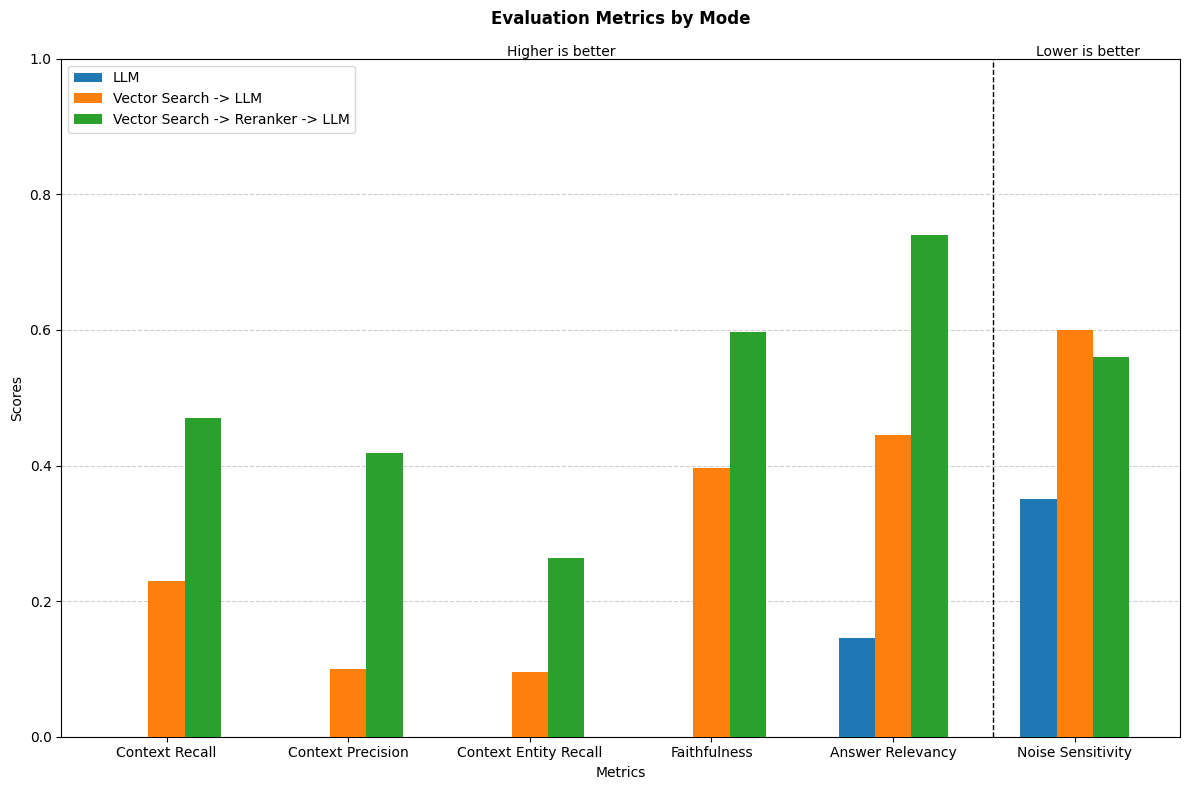

In [20]:
import matplotlib.pyplot as plt

# Define a color preset
colors = plt.get_cmap('tab10').colors

# Plotting the grouped bar chart for each numerical column in grouped_eval_results
numeric_columns = grouped_eval_results.columns

fig, ax = plt.subplots(figsize=(12, 8))

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r = list(range(len(numeric_columns)))

# Plot each mode as a group of bars
for i, mode in enumerate(grouped_eval_results.index):
    ax.bar([x + i * bar_width for x in r], grouped_eval_results.loc[mode], width=bar_width, label=mode, color=colors[i % len(colors)], zorder=3)

# Add a vertical line before the last group of bars
last_group_index = len(numeric_columns) - 1  # Index of the last group
split_position = last_group_index - 0.25  # Position of the vertical line

ax.axvline(split_position, color='black', linestyle='--', linewidth=1)
ax.set_ylim(0, 1.0)
# Add labels above the chart, below the title
y_pos = ax.get_ylim()[1]  # Slightly above the highest bar

ax.text(split_position / 2, y_pos, 'Higher is better', ha='center', va='bottom', fontsize=10)
ax.text(((split_position + last_group_index) / 2)+0.4, y_pos, 'Lower is better', ha='center', va='bottom', fontsize=10)

# Add a grid in the background
ax.grid(True, linestyle="--", alpha=0.6, axis='y', zorder=4)




# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics by Mode', pad=25, fontweight="bold")  # Adjust title spacing
ax.set_xticks([x + bar_width * (len(grouped_eval_results.index) - 1) / 2 for x in r])
ax.set_xticklabels(numeric_columns)

# Move legend outside the chart, aligned to the right
ax.legend()


plt.tight_layout()
plt.show()


